## Python自动生成PDF文件

使用类库：reportlab (https://www.reportlab.com/)  
安装方法：pip install reportlab

实现步骤：
1. 引入相关包
2. 添加标题文字
3. 添加正文文字
4. 添加表格(借助pandas读取excel生成表格)
5. 添加图片(借助matplotlib绘图生成图片)
6. 生成PDF文件

### 1. 引入相关包

In [1]:
from reportlab.pdfbase import pdfmetrics
from reportlab.pdfbase.ttfonts import TTFont
from reportlab.lib.styles import getSampleStyleSheet,ParagraphStyle
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer,Image,Table,TableStyle
from reportlab.lib.enums import TA_CENTER,TA_LEFT,TA_JUSTIFY
from reportlab.lib import colors
from reportlab.lib.pagesizes import A4
from reportlab.lib.units import inch

In [2]:
### 设置中文字体名称为微软雅黑，msyh.ttf需要自己指定文件路径
pdfmetrics.registerFont(TTFont('msyh', 'msyh.ttf'))

In [3]:
# 容纳所有的PDF的内容
elements = []

### 2. 添加标题文字

In [4]:
# 读取reportlab定义好的样式表
style = getSampleStyleSheet()

In [5]:
# 可以用两个问号，查看有多少种现成的样式
getSampleStyleSheet??

In [6]:
title = """ <para> <font face="msyh"> 北京2019年天气数据 </font> </para>"""
elements.append(Paragraph(title, style['Title']))
elements.append(Spacer(1, 0.2*inch))

### 3. 添加正文文字

In [7]:
description = """
        <para>
            <font face="msyh">
                下文展示了2019年北京天气数据按月表格、以及按月平均温度对比图
            </font>
        </para>"""
elements.append(Paragraph(description, style["BodyText"]))
elements.append(Spacer(1, 0.2*inch))

### 4. 添加表格

In [8]:
import pandas as pd
import numpy as np

In [9]:
df = pd.read_csv("./beijing_tianqi_2019.csv")

In [10]:
df.head()

,ymd,bWendu,yWendu,tianqi,fengxiang,fengli,aqi,aqiInfo,aqiLevel
0,2019-01-01,1℃,-10℃,晴~多云,西北风,1级,56,良,2
1,2019-01-02,1℃,-9℃,多云,东北风,1级,60,良,2
2,2019-01-03,2℃,-7℃,霾,东北风,1级,165,中度污染,4
3,2019-01-04,2℃,-7℃,晴,西北风,2级,50,优,1
4,2019-01-05,0℃,-8℃,多云,东北风,2级,29,优,1


In [11]:
# 把bWendu温度列从字符串变成数字
df["bWendu"] = df["bWendu"].str.replace("℃", "").astype(int)
# 添加月份数字列
df["month"] = pd.to_datetime(df["ymd"]).dt.month

In [12]:
df[["ymd", "month", "bWendu"]].head()

,ymd,month,bWendu
0,2019-01-01,1,1
1,2019-01-02,1,1
2,2019-01-03,1,2
3,2019-01-04,1,2
4,2019-01-05,1,0


In [13]:
table = df.groupby("month")["bWendu"].agg(mean=np.mean, max=np.max, min=np.min).reset_index()

In [14]:
table

,month,mean,max,min
0,1,4.161290,10,-2
1,2,5.250000,14,-3
2,3,15.741935,25,11
3,4,20.900000,28,9
4,5,29.322581,37,23
5,6,32.233333,36,25
6,7,32.935484,38,26
7,8,30.387097,33,27
8,9,29.333333,35,24
9,10,19.225806,30,12


In [15]:
# 平均值保留2位小数
table["mean"] = table["mean"].map(lambda x:round(x,2))
table["month"] = table["month"].map(lambda x: f"{x}月")
table

,month,mean,max,min
0,1月,4.16,10,-2
1,2月,5.25,14,-3
2,3月,15.74,25,11
3,4月,20.90,28,9
4,5月,29.32,37,23
5,6月,32.23,36,25
6,7月,32.94,38,26
7,8月,30.39,33,27
8,9月,29.33,35,24
9,10月,19.23,30,12


In [16]:
# 变成[(1,1,1), (2,2,2)]的形式
table_data  = table.to_numpy().tolist()

In [17]:
table_data = [["月份", "平均温度", "最高温度", "最低温度"]] + table_data

In [18]:
table_data

[['月份', '平均温度', '最高温度', '最低温度'],
 ['1月', 4.16, 10, -2],
 ['2月', 5.25, 14, -3],
 ['3月', 15.74, 25, 11],
 ['4月', 20.9, 28, 9],
 ['5月', 29.32, 37, 23],
 ['6月', 32.23, 36, 25],
 ['7月', 32.94, 38, 26],
 ['8月', 30.39, 33, 27],
 ['9月', 29.33, 35, 24],
 ['10月', 19.23, 30, 12],
 ['11月', 10.37, 18, 3],
 ['12月', 3.87, 10, -5]]

In [19]:
# 添加一个小标题
elements.append(Paragraph("""<para><font face="msyh">按月温度数据：</font></para>""", style["h3"]))

In [20]:
# 表格样式
table_styles = [
    ('GRID', (0,0), (-1,-1), 1, colors.black),
    ('FONTSIZE', (0,0), (-1,-1), 12),
    ('ALIGN', (0,-1), (-1,-1), 'LEFT'),
    ('FONT', (0,0), (-1,-1), 'msyh')
]

# 表格对象
mytable = Table(table_data)
mytab_style = TableStyle(table_styles)
mytable.setStyle(mytab_style)

# 添加对象
elements.append(mytable)
elements.append(Spacer(1, 0.2*inch))

### 5. 添加图片

In [21]:
import matplotlib
import matplotlib.pyplot as plt

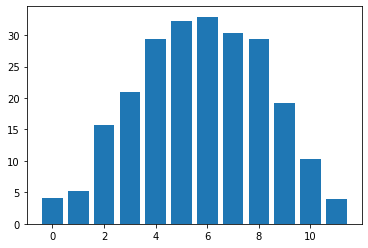

In [22]:
fig = plt.figure()
# 画一个柱状图
plt.bar(table.index, table["mean"])
fig.savefig('plot.png')

In [23]:
# 添加一个小标题
elements.append(Paragraph("""<para><font face="msyh">按月平均温度对比图：</font></para>""", style["h3"]))

In [24]:
# 添加图片
img = Image('plot.png')
elements.append(img)
elements.append(Spacer(1, 0.2*inch))

### 6. 生成PDF文件

In [25]:
doc = SimpleDocTemplate(
    "2019年北京天气数据.pdf", 
    pagesize=(A4[0], A4[1]),
    topMargin = 30,
    bottomMargin = 30)

In [26]:
doc.build(elements)